# Super Resolution GAN

# Case Study :
This project aims to address the challenges faced by law enforcement agencies in analyzing low-resolution or pixelated images during investigations. By leveraging advanced image super-resolution techniques, this project enhances image quality and resolution, enabling police officers to extract valuable details and evidence from otherwise degraded or blurry images.

# Methodology :
This project employs the "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" research paper as the foundation for achieving high-quality image super-resolution. The project leverages the power of deep learning and utilizes TensorFlow 2.0, a popular deep learning framework, to implement the paper's proposed methodology.

The core of the methodology involves training a generative adversarial network (GAN) architecture, consisting of a generator network and a discriminator network. The generator network learns to transform low-resolution input images into high-resolution outputs, while the discriminator network distinguishes between generated high-resolution images and real high-resolution images. The GAN framework trains both networks simultaneously, ensuring that the generated images are photo-realistic and visually coherent.







# Implementation


## Importing the Essential libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpg
import cv2
import os
import zipfile
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Dense, Flatten, Input,BatchNormalization,PReLU,LeakyReLU,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.nn import depth_to_space
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.math import reduce_mean,square
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy
from tensorflow.keras import Sequential


## Building the Generator (SRResNet)
The super-resolution residual network (SRResNet) and the generator are the same thing. The generator network architecture is actually quite simple - just a bunch of convolutional layers, residual blocks, and pixel shuffling layers!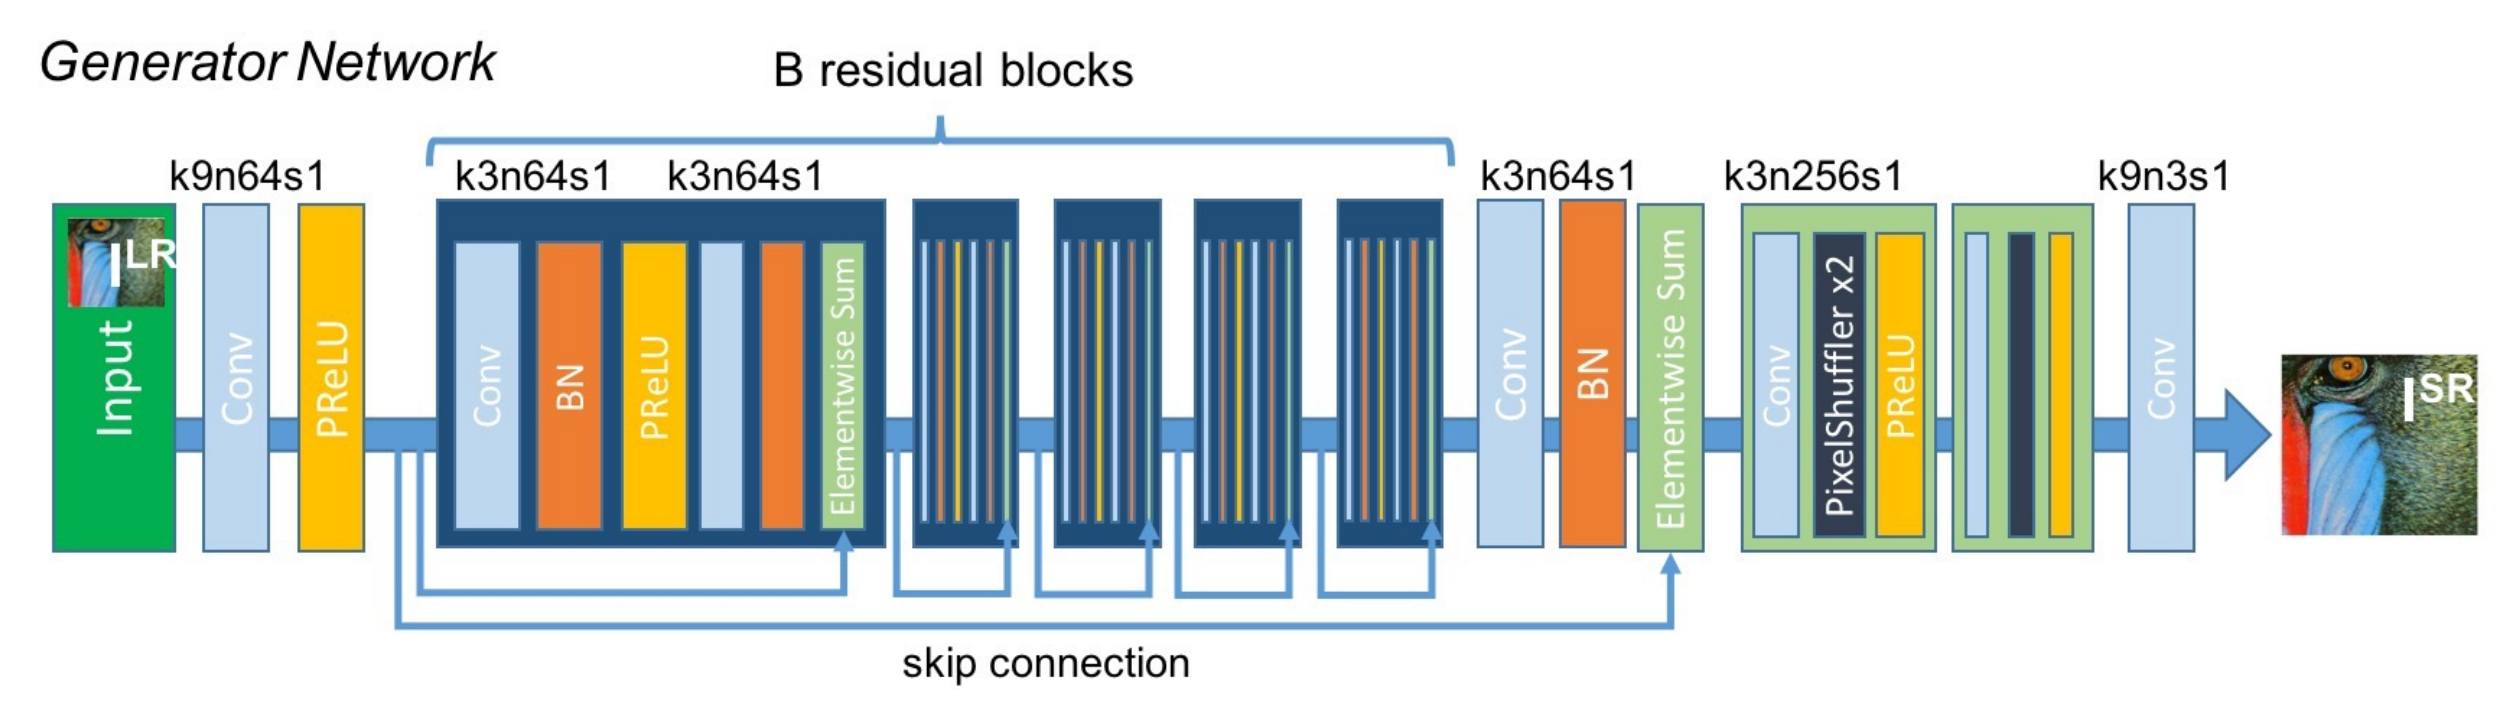

In [ ]:
def residual_blocks(input):
  x = Conv2D(64,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = PReLU()(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Concatenate()([input,x])
  return x

def subpixel(input):
  x = Conv2D(256*2,(3,3),padding='same')(input)
  x = depth_to_space(x,2)
  x = PReLU()(x)
  return x

def generator():
  inputs = Input(shape=(96,96,3))
  x1 = Conv2D(64,(9,9),padding='same')(inputs)
  x1 = PReLU()(x1)
  r = residual_blocks(x1)
  for _ in range(15):
    r = residual_blocks(r)
  x2 = Conv2D(64,(3,3),padding='same')(r)
  x2 = BatchNormalization()(x2)
  merge = Concatenate()([x2,x1])

  x = subpixel(merge)
  x = subpixel(x)
  output = Conv2D(3,(9,9),padding='same')(x)


  model = Model(inputs,output)
  return model


In [ ]:
g_model = generator()
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 96, 96, 64)   589824      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

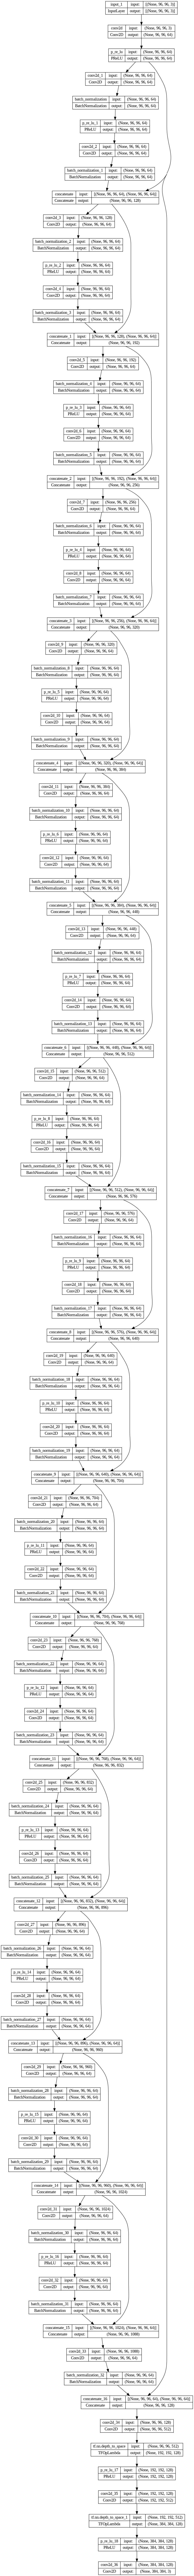

In [ ]:
plot_model(g_model,show_shapes=True)

## Building Discriminator :
The discriminator architecture is also relatively straightforward, just one big sequential model
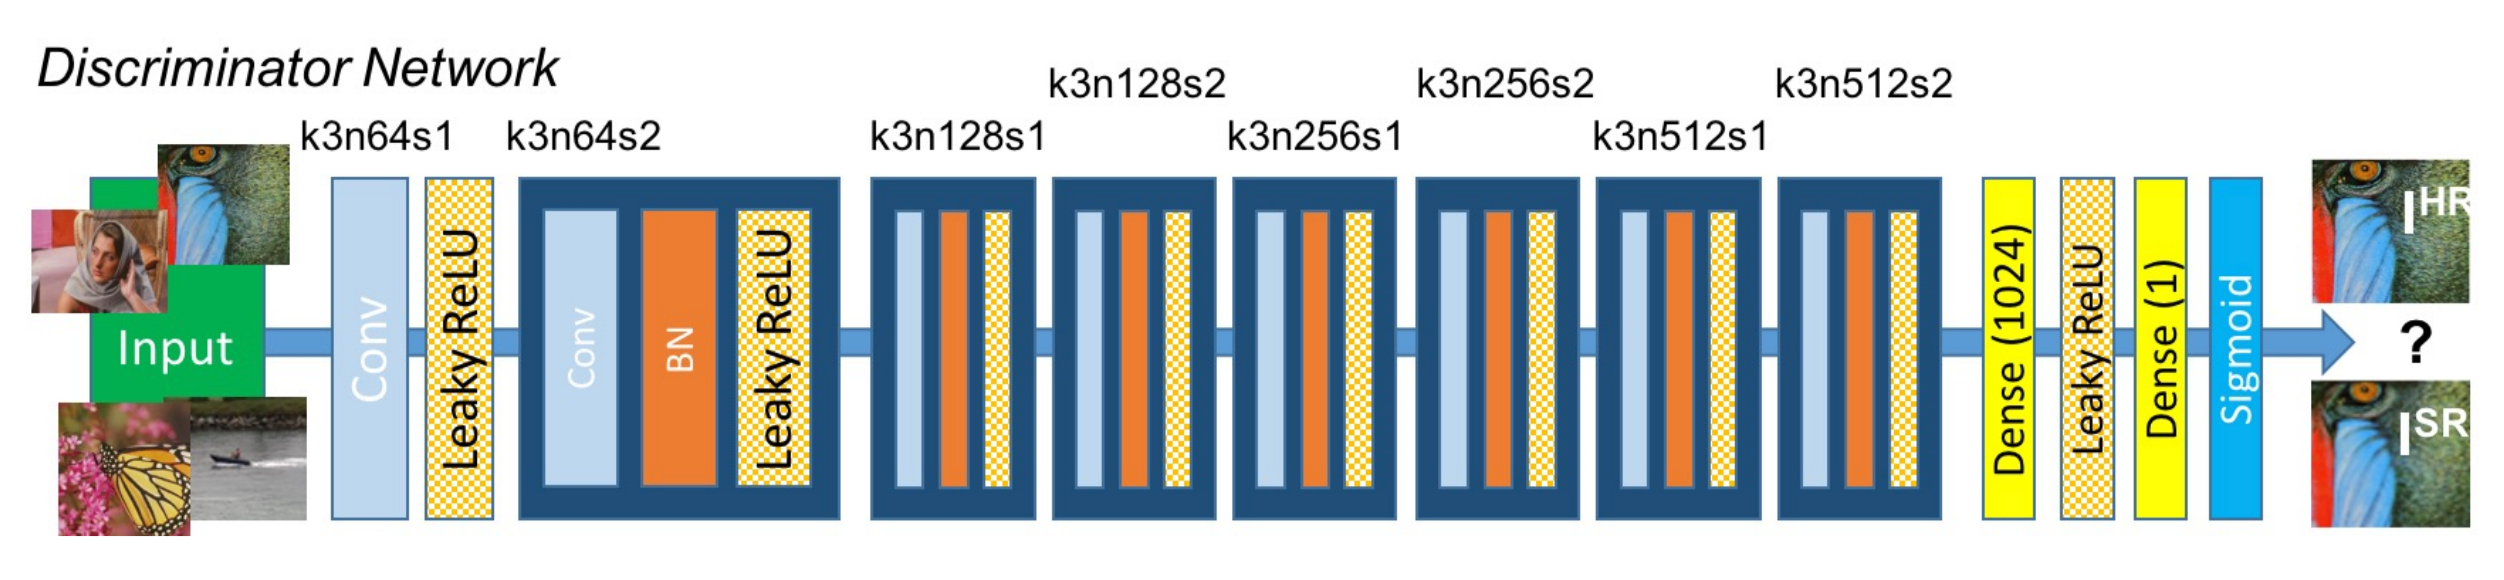

In [ ]:
def conv_block(input,n_channels):
  x = Conv2D(n_channels,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(n_channels,(3,3),padding='same',strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  return x


def discriminator():
  input = Input(shape=(384,384,3))
  c1 = Conv2D(64,(3,3),padding='same')(input)
  c1 = LeakyReLU(0.2)(c1)
  c1 = Conv2D(64,(3,3),padding='same',strides=(2,2))(c1)
  c1 = BatchNormalization()(c1)
  c1 = LeakyReLU(0.2)(c1)
  c2 = conv_block(c1,128)
  c3 = conv_block(c2,256)
  c4 = conv_block(c3,512)
  x = Flatten()(c4)
  x = Dense(1024)(x)
  x = LeakyReLU(0.2)(x)
  output = Dense(1,activation='sigmoid')(x)
  model = Model([input],output)
  return model

In [ ]:
d_model = discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 384, 384, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 384, 384, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 batch_normalization_33 (Bat  (None, 192, 192, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 192, 192, 64)      0         
                                                           

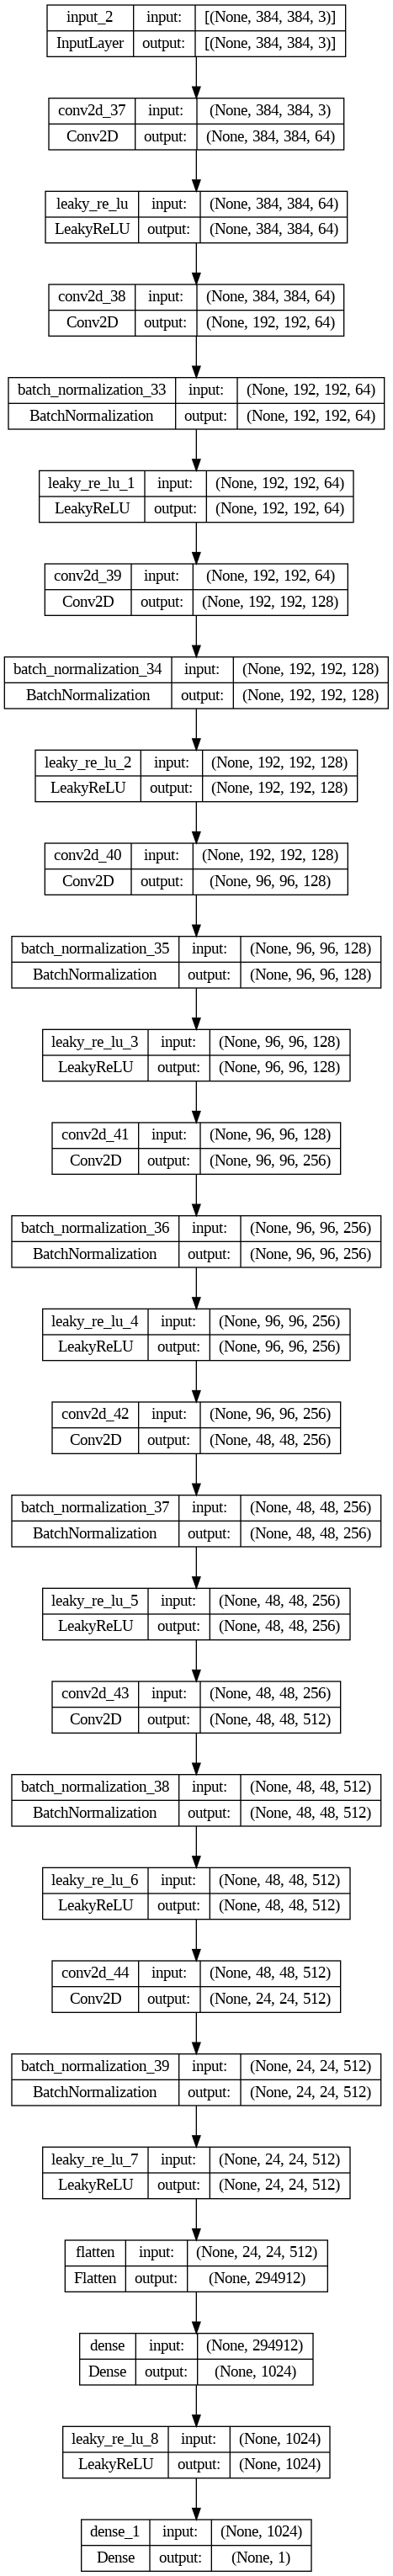

In [ ]:
plot_model(d_model,show_shapes=True)


## Defining the loss Functions:
 1. Generaor_loss = Perceptual_loss ( vgg_loss ) + Adeversarial_loss
 2. Discriminator_loss = Adversarial_loss ( Binary_crossEntropy )

In [ ]:

def vgg_loss(generated_hr_image, real_hr_image):
  selected_layers = ['block5_conv4' ]
  vgg_model = VGG19(include_top=False)
  vgg_model.trainable = False
  feature_extractor = Model(vgg_model.input,outputs=[vgg_model.get_layer(layer).output for layer in selected_layers])

  real_hr_image_features = feature_extractor(real_hr_image)
  generated_hr_image_features = feature_extractor(generated_hr_image)
  mse = MeanSquaredError()
  loss = mse(real_hr_image_features,generated_hr_image_features)
  return loss


In [ ]:
from tensorflow import ones_like,zeros_like

def generator_loss(fake_output,real_hr_image,generated_hr_image):
  adversarial_loss = BinaryCrossentropy(from_logits=True)(ones_like(fake_output), fake_output)
  perceptual_loss = vgg_loss(generated_hr_image,real_hr_image)
  total_loss = adversarial_loss + (1/12.75)*perceptual_loss
  return total_loss

def discriminator_loss(real_output,fake_output):
  loss = BinaryCrossentropy(from_logits=True)
  real_loss = loss(ones_like(real_output), real_output)
  fake_loss = loss(zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss



## Extracting and Preparing data
The dataset which is used is extracted from the [Kaggle_Dataset](/https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution)

In [9]:
data = zipfile.ZipFile('/content/drive/MyDrive/SRGAN_100.zip')
data.extractall()
data.close()

lr_path = '/content/Data/LR'
hr_path = '/content/Data/HR'

lr = []
for image in sorted(os.listdir(lr_path)):
  img_path = os.path.join(lr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img/255.
  img = img.astype('float32')
  lr.append(img)

hr =[]
for image in sorted(os.listdir(hr_path)):
  img_path = os.path.join(hr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img/255.
  img = img.astype('float32')
  hr.append(img)

In [10]:
lr[0].shape,hr[0].shape
type(lr[0])

numpy.ndarray

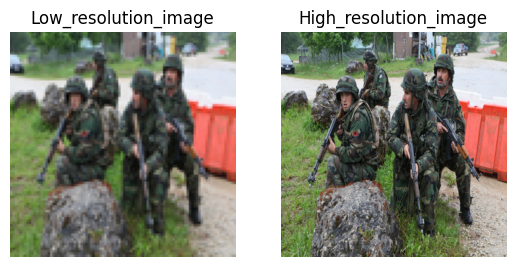

In [13]:

plt.subplot(1,2,1)
plt.imshow(lr[10])
plt.axis('off')
plt.title("Low_resolution_image")

plt.subplot(1,2,2)
plt.imshow(hr[10])
plt.axis('off')
plt.title("High_resolution_image")

plt.show()

In [8]:
lr = np.reshape(lr,(len(lr),96,96,3))
hr = np.reshape(hr,(len(hr),384,384,3))
lr.shape,hr.shape

((100, 96, 96, 3), (100, 384, 384, 3))

# Training the GAN model with the prepared dataset

In [ ]:
from tensorflow import GradientTape,function
generator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)
discriminator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)



def train(lr_images,hr_images):
  with GradientTape() as gen_tape, GradientTape() as dis_tape:
    # Training_discriminator . .
    generated_image = g_model(lr_images,training=True)
    real_output = d_model(hr_images,training = True)
    fake_output = d_model(generated_image,training=True)
    d_loss = discriminator_loss(real_output,fake_output)
    dis_gradients = dis_tape.gradient(d_loss,d_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(dis_gradients,d_model.trainable_variables))
    # Training Generator + discriminator

    gen_out = g_model(lr_images,training = True)
    d_out = d_model(gen_out,training=False)
    gen_loss = generator_loss(d_out,hr_images,gen_out)
    gen_gradients = gen_tape.gradient(gen_loss,g_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradients,g_model.trainable_variables))
    print(d_loss,gen_loss)

for i in range(100):
  n = np.random.randint(0,100,2)
  train(lr[n],hr[n])














/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


80134624/80134624 [==============================] - 1s 0us/step


tf.Tensor(1.3832492, shape=(), dtype=float32) tf.Tensor(0.70140874, shape=(), dtype=float32)
tf.Tensor(1.3861396, shape=(), dtype=float32) tf.Tensor(0.6990426, shape=(), dtype=float32)
tf.Tensor(1.3874125, shape=(), dtype=float32) tf.Tensor(0.69836694, shape=(), dtype=float32)
tf.Tensor(1.3870307, shape=(), dtype=float32) tf.Tensor(0.69709516, shape=(), dtype=float32)
tf.Tensor(1.3836397, shape=(), dtype=float32) tf.Tensor(0.6966745, shape=(), dtype=float32)
tf.Tensor(1.3905689, shape=(), dtype=float32) tf.Tensor(0.6975221, shape=(), dtype=float32)
tf.Tensor(1.3891082, shape=(), dtype=float32) tf.Tensor(0.6945689, shape=(), dtype=float32)
tf.Tensor(1.3877943, shape=(), dtype=float32) tf.Tensor(0.6955743, shape=(), dtype=float32)
tf.Tensor(1.3930664, shape=(), dtype=float32) tf.Tensor(0.69236326, shape=(), dtype=float32)
tf.Tensor(1.3880031, shape=(), dtype=float32) tf.Tensor(0.6960383, shape=(), dtype=float32)
tf.Tensor(1.3876784, shape=(), dtype=float32) tf.Tensor(0.6954447, shape=(),

ResourceExhaustedError: ignored

## Result :
The results obtained from the image super-resolution process have demonstrated significant improvements in image quality and resolution. The project's effectiveness is evident in the visually enhanced images, which reveal finer details and enhance the visibility of critical elements. By successfully restoring important information from low-quality images, police officers can better identify individuals, objects, and contextual details, thus aiding investigations and potentially leading to quicker resolutions.

## Impact of this project :
The image super-resolution project offers tangible benefits to law enforcement agencies and investigators. By utilizing this solution, police officers gain access to enhanced image analysis capabilities, enabling them to extract vital evidence, identify suspects, and reconstruct crime scenes more accurately. Ultimately, the project's application contributes to more efficient and effective investigations, potentially leading to improved public safety and enhanced criminal justice outcomes